# MOVIE PREDICTION

###  Part 1 : Data and Library Imports

##### Importing Packages

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer

##### Loading in Data

In [ ]:
prime_df = pd.read_csv('prime_titles.csv')
hulu_df=pd.read_csv('hulu_titles.csv')
netflix_df=pd.read_csv('netflix_titles.csv')
hbo_df = pd.read_csv('titles_hbo.csv')

hbo_creds=pd.read_csv('credits_hbo.csv')
prime_creds=pd.read_csv('credits_prime.csv')
hulu_creds=pd.read_csv('credits_hulu.csv')
netflix_creds=pd.read_csv('credits_netflix.csv')

##### Creating a new column to indicate which streaming platform the data is from 

In [ ]:
prime_df = (prime_df.assign(service="amazon"))
hulu_df = (hulu_df.assign(service="hulu"))
netflix_df=(netflix_df.assign(service="netflix"))
hbo_df=(hbo_df.assign(service="hbo"))

In [ ]:
prime_df=(pd.merge(prime_df, prime_creds, on='id'))
hulu_df=(pd.merge(hulu_df, hulu_creds, on='id'))
netflix_df=(pd.merge(netflix_df, netflix_creds, on='id'))
hbo_df=(pd.merge(hbo_df, hbo_creds, on='id'))

##### Combining both dataframes into one massive one

In [ ]:
df=pd.concat([prime_df,hulu_df,netflix_df,hbo_df],axis=0,join='inner')

### Part 2 : Data Exploration

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300343 entries, 0 to 66392
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300343 non-null  object 
 1   title                 300342 non-null  object 
 2   type                  300343 non-null  object 
 3   description           300198 non-null  object 
 4   release_year          300343 non-null  int64  
 5   age_certification     178084 non-null  object 
 6   runtime               300343 non-null  int64  
 7   genres                300343 non-null  object 
 8   production_countries  300343 non-null  object 
 9   seasons               36845 non-null   float64
 10  imdb_id               287507 non-null  object 
 11  imdb_score            286073 non-null  float64
 12  imdb_votes            285893 non-null  float64
 13  tmdb_popularity       300317 non-null  float64
 14  tmdb_score            287815 non-null  float64
 15  s

In [ ]:
print(df.describe)

<bound method NDFrame.describe of               id                title   type  \
0        ts20945    The Three Stooges   SHOW   
1        ts20945    The Three Stooges   SHOW   
2        ts20945    The Three Stooges   SHOW   
3        tm19248          The General  MOVIE   
4        tm19248          The General  MOVIE   
...          ...                  ...    ...   
66388  tm1067128            Algo Azul  MOVIE   
66389  tm1067128            Algo Azul  MOVIE   
66390  tm1067128            Algo Azul  MOVIE   
66391  tm1067128            Algo Azul  MOVIE   
66392   tm989132  The Infamous Future  MOVIE   

                                             description  release_year  \
0      The Three Stooges were an American vaudeville ...          1934   
1      The Three Stooges were an American vaudeville ...          1934   
2      The Three Stooges were an American vaudeville ...          1934   
3      During America’s Civil War, Union spies steal ...          1926   
4      During Ameri

In [ ]:
df['actor'] = df.apply(lambda row: row['name'] if row['role'] == 'ACTOR' else None, axis=1)
df['director'] = df.apply(lambda row: row['name'] if row['role'] != 'ACTOR' else None, axis=1)

In [ ]:
df = df.groupby('id', as_index=False).agg({
    'title': 'first',
    'type': 'first',
    'description': 'first',
    'release_year': 'first',
    'age_certification': 'first',
    'runtime': 'first',
    'genres': 'first',
    'production_countries': 'first',
    'seasons': 'first',
    'imdb_id': 'first',
    'imdb_score': 'first',
    'imdb_votes': 'first',
    'tmdb_popularity': 'first',
    'tmdb_score': 'first',
    'service': 'first',
    'actor': lambda x: list(x),
    'person_id': lambda x: list(x),
    'name': lambda x: list(x),
    'character': lambda x: list(x),
    'role': lambda x: list(x),
    'director': lambda x: list(x)
})


In [ ]:
def extract_director(directors_list):
    for director in directors_list:
        if director is not None:
            if isinstance(director, dict):
                return director['name']
            else:
                return director
    return None

df['director'] = df['director'].apply(extract_director)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19225 entries, 0 to 19224
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    19225 non-null  object 
 1   title                 19224 non-null  object 
 2   type                  19225 non-null  object 
 3   description           19189 non-null  object 
 4   release_year          19225 non-null  int64  
 5   age_certification     9514 non-null   object 
 6   runtime               19225 non-null  int64  
 7   genres                19225 non-null  object 
 8   production_countries  19225 non-null  object 
 9   seasons               4460 non-null   float64
 10  imdb_id               17870 non-null  object 
 11  imdb_score            17669 non-null  float64
 12  imdb_votes            17641 non-null  float64
 13  tmdb_popularity       19215 non-null  float64
 14  tmdb_score            17586 non-null  float64
 15  service            

##### Dealing with missing values

In [ ]:
df.isna().sum()

id                          0
title                       1
type                        0
description                36
release_year                0
age_certification        9711
runtime                     0
genres                      0
production_countries        0
seasons                 14765
imdb_id                  1355
imdb_score               1556
imdb_votes               1584
tmdb_popularity            10
tmdb_score               1639
service                     0
actor                       0
person_id                   0
name                        0
character                   0
role                        0
director                 4035
dtype: int64

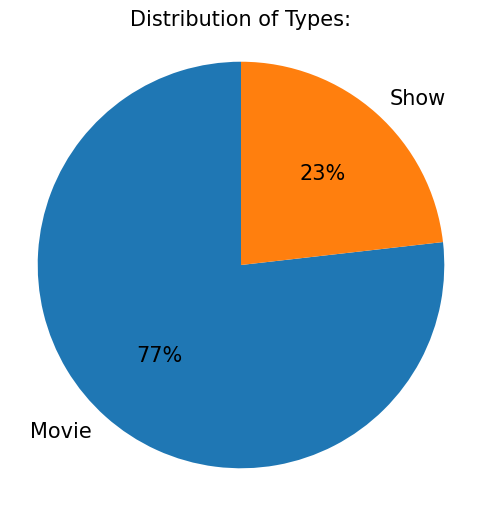

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Distribution of Types:', fontsize=15)
plt.pie(df.type.value_counts(), 
        labels=['Movie', 'Show'],
        textprops={"fontsize":15},
        radius=1.1, startangle=90,
        autopct='%.0f%%')
plt.show()

In [ ]:
movie_count = df[df['type'] == 'MOVIE'].shape[0]
show_count = df[df['type'] == 'SHOW'].shape[0]
print(f"Number of movies: {movie_count}")
print(f"Number of TV shows: {show_count}")

Number of movies: 14765
Number of TV shows: 4460


##### Summary variable

In [ ]:
descriptions = (pd.DataFrame(df.description.dropna())).reset_index()
mas = []
for i in range(5832):
  w = descriptions.description[i]
  ww = w.split()
  mas.append(ww)

data = []
for i in mas:
    for j in range(len(i)):
        data.append(i[j].lower())
        
big_string=''
for i in range(len(data)):
    big_string+=(data[i]+' ')

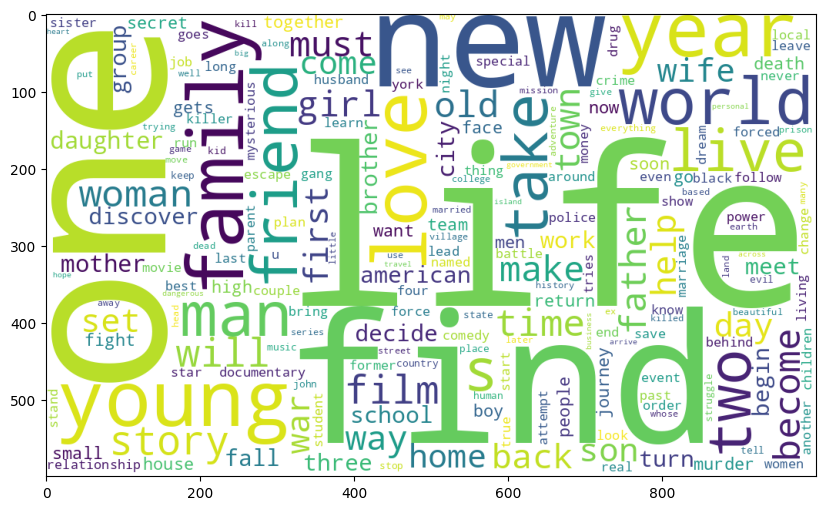

In [ ]:
wordCloud = WordCloud(width = 1000, height = 600, random_state=1,background_color='white', collocations=False).generate(big_string)

plt.figure(figsize=(10,6))
plt.imshow(wordCloud)

#### Part 3 : Data Cleaning

##### Genre and production country columns are lists- need to get a top category

#####  1. genre 

In [ ]:
df['genres'] = df['genres'].str.strip("[]'")
genres_df = df['genres'].str.split(', ', expand=True)
genres_df.columns = [f'genre_{i}' for i in range(genres_df.shape[1])]
df = pd.concat([df, genres_df], axis=1)
df['genre_0'] = df['genre_0'].str.strip("'")
df['genre_1'] = df['genre_1'].str.strip("'")
df['genre_2'] = df['genre_2'].str.strip("'")
df['genre_3'] = df['genre_3'].str.strip("'")
df['genre_4'] = df['genre_4'].str.strip("'")
df['genre_5'] = df['genre_5'].str.strip("'")
df['genre_6'] = df['genre_6'].str.strip("'")
df['genre_7'] = df['genre_7'].str.strip("'")
df['genre_8'] = df['genre_8'].str.strip("'")


df.drop(['genres'], axis=1, inplace=True)

In [ ]:
df['genre_0'].unique()

array(['scifi', 'western', 'drama', '', 'action', 'music', 'romance',
       'comedy', 'horror', 'thriller', 'animation', 'fantasy',
       'documentation', 'crime', 'family', 'sport', 'history', 'war',
       'european', 'reality'], dtype=object)

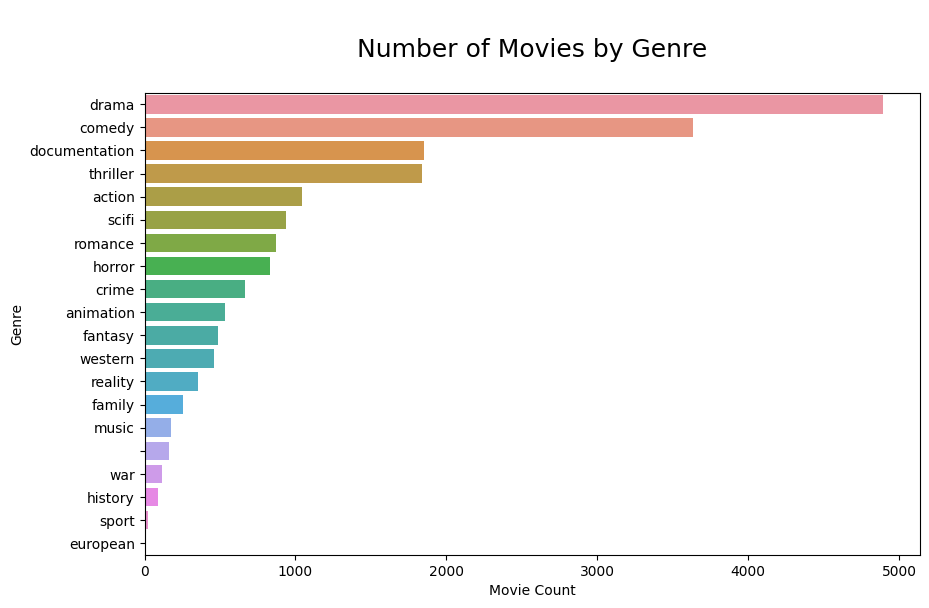

In [ ]:
bp_df = pd.DataFrame(df.genre_0.value_counts())
order = bp_df.index
plt.figure(figsize=(10,6))
plt.title('\nNumber of Movies by Genre\n', fontsize=18)
sns.countplot(y=df.genre_0, order=order)
plt.xlabel('Movie Count')
plt.ylabel('Genre')
plt.show()

#####  2. Seasons  

In [ ]:
df.loc[df['type'] == 'MOVIE', ['seasons']] = 0

#####  3. Production Countries 

In [ ]:
df['production_countries'] = df['production_countries'].str.replace(r"[", '').str.replace(r"'", '').str.replace(r"]", '')
df['lead_prod_country'] = df['production_countries'].str.split(',').str[0]

# Let's also add a number of countries, envolved in movie making, so that we save a little more data
df['prod_countries_cnt'] = df['production_countries'].str.split(',').str.len()
df.lead_prod_country = df.lead_prod_country.replace('', np.nan)

<ipython-input-120-511c28008636>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['production_countries'] = df['production_countries'].str.replace(r"[", '').str.replace(r"'", '').str.replace(r"]", '')


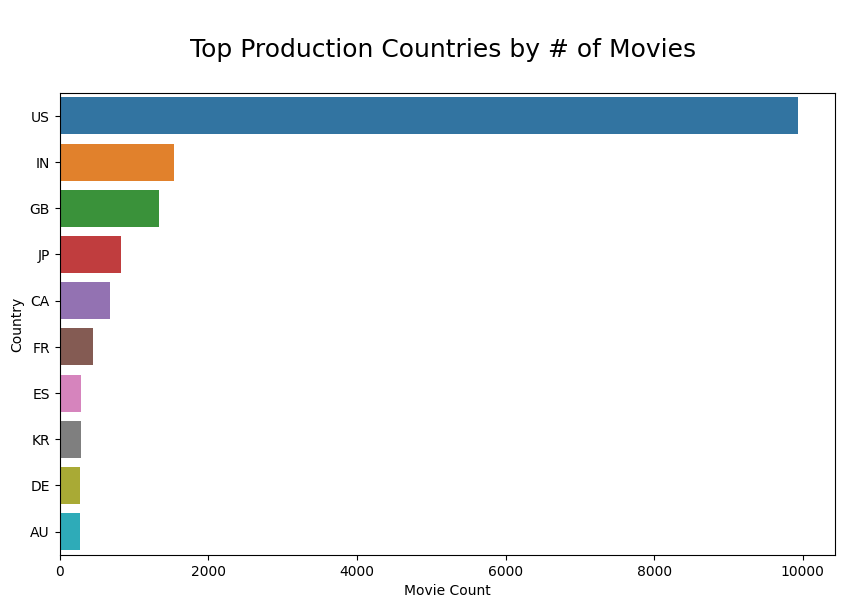

In [ ]:
bp_df = pd.DataFrame(df.lead_prod_country.value_counts()).head(10)
order = bp_df.index
plt.figure(figsize=(10,6))
plt.title('\nTop Production Countries by # of Movies \n', fontsize=18)
sns.countplot(y=df.lead_prod_country, order=order)
plt.xlabel('Movie Count')
plt.ylabel('Country')
plt.show()

In [ ]:
#df.dropna(inplace=True)

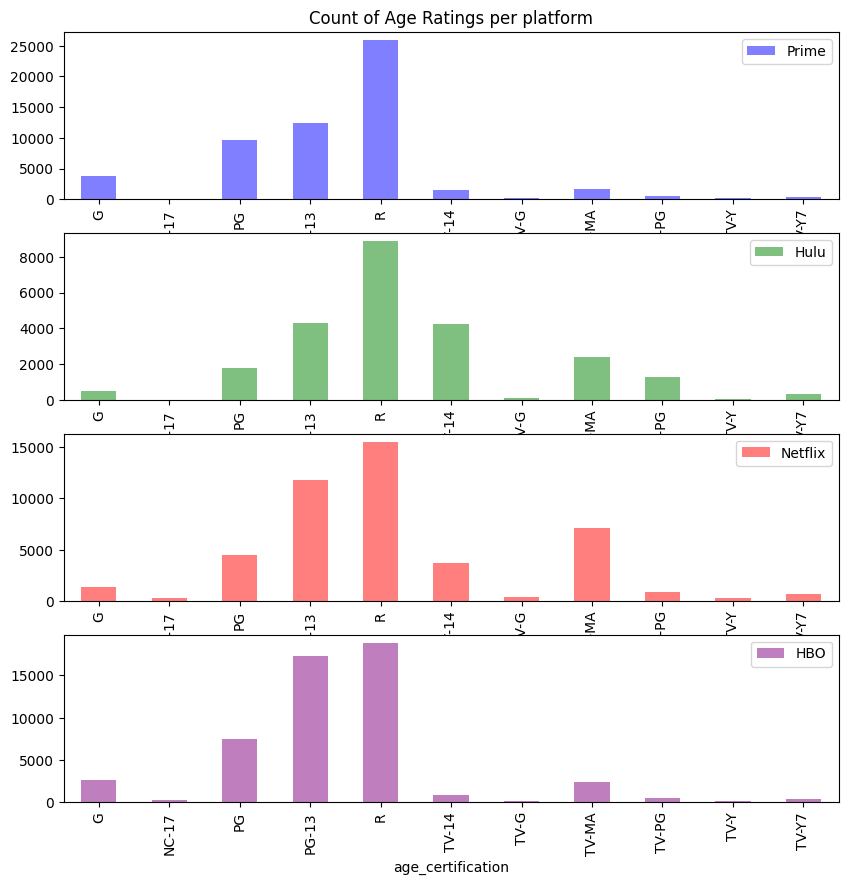

In [ ]:
fig, ax = plt.subplots(4,figsize=(10, 10))

# Plot the first line
prime_df.groupby(['age_certification']).size().plot.bar(ax=ax[0], color='blue', alpha=0.5, label='Prime')

# Plot the second line
hulu_df.groupby(['age_certification']).size().plot.bar(ax=ax[1], color='green', alpha=0.5, label='Hulu')
# Plot the third line
netflix_df.groupby(['age_certification']).size().plot.bar(ax=ax[2], color='red', alpha=0.5, label='Netflix')
# Plot the forth line
hbo_df.groupby(['age_certification']).size().plot.bar(ax=ax[3], color='purple', alpha=0.5, label='HBO')

# Set the title and labels
ax[0].set_title('Count of Age Ratings per platform')
ax[2].set_xlabel('Age Certification')



# Set the legend
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

# Show the plot
plt.show()

#### Cleaning Actor Column

In [ ]:
# converting the list to a string

In [ ]:
df['actor'] = df['actor'].apply(lambda x: ' '.join([a if a is not None else '' for a in x]))

#####  3. Weighted ratings

In [ ]:
v=df['imdb_votes']
R=df['imdb_score']
c=df['imdb_score'].mean()
m=df['imdb_votes'].quantile(0.9)

In [ ]:
df['weighted_avg']=((R*v)+ (c*m))/(v+m)

Text(0, 0.5, 'Movie Name')

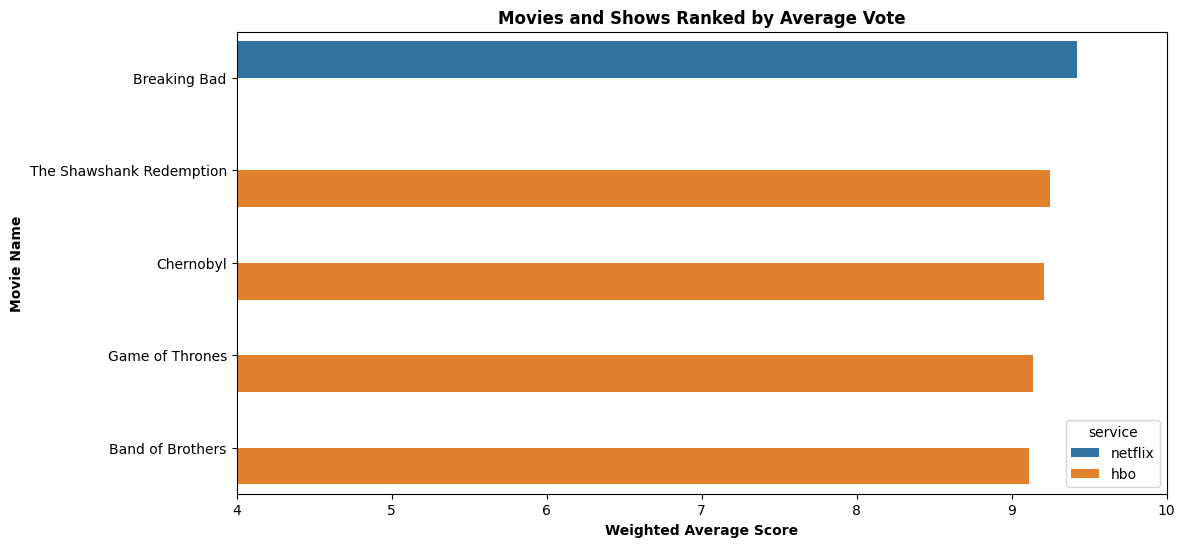

In [ ]:
weight_average= df.sort_values('weighted_avg',ascending=False)


plt.figure(figsize=(12, 6))
axis1=sns.barplot(x=weight_average['weighted_avg'].head(5),y=weight_average['title'].head(5),
                   hue=weight_average['service'].head(5),data=weight_average)
plt.xlim(4,10)

plt.title('Movies and Shows Ranked by Average Vote',weight='bold')
plt.xlabel('Weighted Average Score',weight='bold')
plt.ylabel('Movie Name',weight='bold')


In [ ]:
print(df['service'].nunique())

4


In [ ]:
df.corr()

<ipython-input-130-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,prod_countries_cnt,weighted_avg
release_year,1.000000,-0.048988,0.038216,0.024434,-0.005286,0.074379,0.143127,0.041268,-0.042537
runtime,-0.048988,1.000000,-0.388854,-0.146373,0.158323,-0.020891,-0.198378,0.135602,-0.005001
seasons,0.038216,-0.388854,1.000000,0.215851,0.037465,0.127256,0.211140,-0.064168,0.206675
imdb_score,0.024434,-0.146373,0.215851,1.000000,0.206806,0.071861,0.633281,0.020243,0.523006
imdb_votes,-0.005286,0.158323,0.037465,0.206806,1.000000,0.201364,0.154168,0.088889,0.602519
tmdb_popularity,0.074379,-0.020891,0.127256,0.071861,0.201364,1.000000,0.109545,0.009738,0.166118
tmdb_score,0.143127,-0.198378,0.211140,0.633281,0.154168,0.109545,1.000000,-0.001636,0.375559
prod_countries_cnt,0.041268,0.135602,-0.064168,0.020243,0.088889,0.009738,-0.001636,1.000000,0.027508
weighted_avg,-0.042537,-0.005001,0.206675,0.523006,0.602519,0.166118,0.375559,0.027508,1.000000


#####  4. Release Year

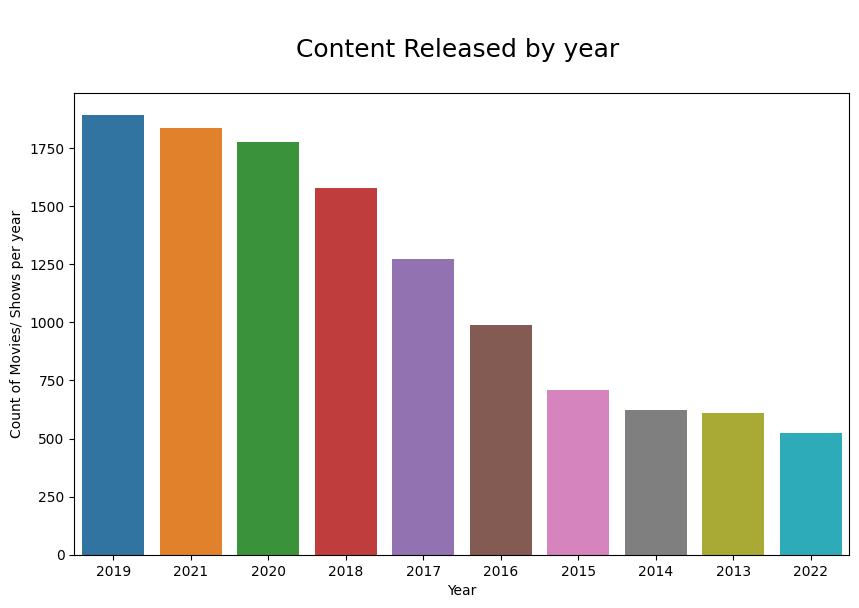

In [ ]:
bp_df = pd.DataFrame(df.release_year.value_counts()).head(10)
order = bp_df.index
plt.figure(figsize=(10,6))
plt.title('\nContent Released by year \n', fontsize=18)
sns.countplot(x=df.release_year, order=order)
plt.xlabel('Year')
plt.ylabel('Count of Movies/ Shows per year')
plt.show()

In [ ]:
df.columns

Index(['id', 'title', 'type', 'description', 'release_year',
       'age_certification', 'runtime', 'production_countries', 'seasons',
       'imdb_id', 'imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score',
       'service', 'actor', 'person_id', 'name', 'character', 'role',
       'director', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4',
       'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9',
       'lead_prod_country', 'prod_countries_cnt', 'weighted_avg'],
      dtype='object')

###### Checking for and getting rid of NA vals

In [ ]:
df.drop(df.loc[((df['tmdb_score'].isna()) & (df['tmdb_popularity'].isna()))].index, 
                axis = 0, inplace = True)

In [ ]:
((df.isnull().sum()/df.shape[0])*100).sort_values(ascending = False)

genre_9                 99.994796
genre_8                 99.911527
genre_7                 99.687744
genre_6                 99.021598
genre_5                 97.054385
genre_4                 91.647151
genre_3                 79.354671
genre_2                 56.013531
age_certification       50.491803
genre_1                 26.786365
director                20.983607
tmdb_score               8.477752
weighted_avg             8.227947
imdb_votes               8.227947
imdb_score               8.082227
imdb_id                  7.051782
lead_prod_country        3.143378
description              0.171741
prod_countries_cnt       0.000000
genre_0                  0.000000
id                       0.000000
role                     0.000000
character                0.000000
title                    0.000000
person_id                0.000000
actor                    0.000000
service                  0.000000
tmdb_popularity          0.000000
seasons                  0.000000
production_cou

In [ ]:
df[(df.type == 'SHOW') & (df.imdb_score >= 9) & (df.tmdb_score>=9)][['actor', 'imdb_score', 'tmdb_score', 'title']].reset_index().drop('index', axis = 1)

,actor,imdb_score,tmdb_score,title
0,Lilía Herrera Mosk Marrero Carlos Kapistrán Mi...,9.0,10.000,Corazón Contento
1,Hailee Steinfeld Ella Purnell Kevin Alejandro ...,9.0,9.081,Arcane
2,William Toti,9.3,9.100,9/11: One Day in America
3,Jonathan Roumie Elizabeth Tabish Jordan Walker...,9.4,9.400,The Chosen
4,Alyssa Chia James Wen Kang Ren Wu Chen Yu Pets...,9.0,9.400,The World Between Us


In [ ]:
df.drop(['id', 'imdb_id','person_id','genre_3','genre_4','genre_5','genre_6','genre_7','genre_8','character','role'], axis=1, inplace=True)

In [ ]:
df.head()

,title,type,description,release_year,age_certification,runtime,production_countries,seasons,imdb_score,imdb_votes,...,actor,name,director,genre_0,genre_1,genre_2,genre_9,lead_prod_country,prod_countries_cnt,weighted_avg
0,The Matrix,MOVIE,"Set in the 22nd century, The Matrix tells the ...",1999,R,136,US,0.0,8.7,1857949.0,...,Keanu Reeves Laurence Fishburne Carrie-Anne Mo...,"[Keanu Reeves, Laurence Fishburne, Carrie-Anne...",Lana Wachowski,scifi,action,None,None,US,1,8.643088
1,The Lucky Texan,MOVIE,"Jerry Mason, a young Texan, and Jake Benson, a...",1934,None,61,US,0.0,5.6,1213.0,...,John Wayne Barbara Sheldon Lloyd Whitlock Geor...,"[John Wayne, Barbara Sheldon, Lloyd Whitlock, ...",Robert N. Bradbury,western,action,romance,None,US,1,6.295588
2,Boonie Bears: The Wild Life,MOVIE,Bear brothers Briar and Bramble set off on an ...,2021,None,99,CN,0.0,5.4,117.0,...,Chris Boike Nikki Stinson Tan Xiao 张伟,"[Chris Boike, Nikki Stinson, Tan Xiao, 张伟, Leo...",Leon Ding,scifi,animation,None,None,CN,1,6.311822
3,Je suis Karl,MOVIE,After most of her family is murdered in a terr...,2021,R,126,"CZ, DE",0.0,5.4,1077.0,...,Luna Wedler Jannis Niewöhner Milan Peschel Edi...,"[Luna Wedler, Jannis Niewöhner, Milan Peschel,...",Christian Schwochow,drama,thriller,european,None,CZ,2,6.292989
4,Bad Luck Banging or Loony Porn,MOVIE,"Emi, a school teacher, finds her career and re...",2021,None,106,"HR, LU, GB, RO, CH, CZ",0.0,6.6,6465.0,...,Katia Pascariu Claudia Ieremia Olimpia Mălai N...,"[Katia Pascariu, Claudia Ieremia, Olimpia Măla...",Radu Jude,drama,comedy,None,None,HR,6,6.349798


# Part 3. Model Building 

## Similarity Score

In [ ]:
df['index_column'] = df.index
features = ['title', 'type', 'genre_0', 'description','actor','director', 'imdb_score', 'tmdb_popularity', 'tmdb_score']
for feature in features:
    df[feature] = df[feature].fillna('')
def combined_features(row):
    return row['title']+" "+row['type']+" "+row['genre_0']+" "+row['description']+" "+row['actor']+" "+row['director']+" "+str(row['imdb_score'])+" "+str(row['tmdb_popularity'])+" "+str(row['tmdb_score'])
                                                                                                                    
df["combined_features"] = df.apply(combined_features, axis =1)
vectorizer = CountVectorizer()
matrix_transform = vectorizer.fit_transform(df["combined_features"])
cosine_similarity_rm = cosine_similarity(matrix_transform)

In [ ]:
def select_movie(df, movie_title, number_of_recommendations):
    # Define the columns to be used as features
    features = ['title', 'type', 'genre_0', 'description', 'actor', 'director', 'imdb_score', 'tmdb_popularity', 'tmdb_popularity']
    
    # Create a new dataframe with the selected movie's features
    selected_movie = pd.DataFrame(df[df['title'] == movie_title][features].iloc[0]).transpose()
    
    # Use a CountVectorizer to create a matrix of token counts for each movie's features
    vectorizer = CountVectorizer()
    feature_matrix = vectorizer.fit_transform(df[features].apply(lambda x: ' '.join(str(i) for i in x)))
    
    # Compute the cosine similarity between each pair of movies based on their feature vectors
    cosine_sim = cosine_similarity(feature_matrix)
    
    # Get the index of the selected movie in the cosine similarity matrix
    movie_index = df[df['title'] == movie_title].index[0]
    
    # Get the cosine similarity scores for all movies relative to the selected movie
    similarity_scores = list(enumerate(cosine_sim[movie_index]))
    
    # Sort the movies by their similarity scores, in descending order
    sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    # Get the titles of the top N most similar movies
    top_movies = [df.iloc[i[0]]['title'] for i in sorted_scores[1:number_of_recommendations+1]]
    
    return top_movies

In [ ]:
recommendations = select_movie(df, 'The Lucky Texan', 10)
for recommendation in recommendations:
    print(recommendation)

# Model Evaluation

In [ ]:
# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(df['combined_features'], df['type'], test_size=0.2, random_state=42)

# Train the CountVectorizer model on the training data
cv = CountVectorizer()
train_count_matrix = cv.fit_transform(train_data)

# Transform the testing data using the trained CountVectorizer model
test_count_matrix = cv.transform(test_data)

# Train the model using the training data
clf = MultinomialNB()
clf.fit(train_count_matrix, train_labels)

# Predict the labels of the testing data
predicted_labels = clf.predict(test_count_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


# Cluster Analysis

In [ ]:
# Greating Dummy Variables

In [ ]:
data=df

In [ ]:
# Create dummy variables for categorical columns
dummies = pd.get_dummies(data[['type', 'production_countries', 'genre_0', 'director', 'actor']], drop_first=True)

# Concatenate the dummy variables with the original dataframe
data_1 = pd.concat([df, dummies], axis=1)

# Drop the original categorical columns
#data.drop(['type', 'production_countries', 'genre_0', 'director', 'actor'], axis=1, inplace=True)


In [ ]:
data_1.describe().T

In [ ]:
numeric_columns = data_1.select_dtypes(include=np.number).columns.tolist()
data_numeric = data_1[numeric_columns]

imputer = SimpleImputer(strategy='median')
data_imputed = imputer.fit_transform(data_numeric)

data_std = (data_imputed - data_imputed.mean()) / data_imputed.std()


pca = PCA(n_components=0.95)
data_pca = pca.fit_transform(data_std)

In [ ]:
K = range(10, 80)
models = [KMeans(n_clusters = k, random_state=8, n_init=10,max_iter = 100).fit(data_pca) for k in K]
dist = [model.inertia_ for model in models]

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(K, dist, marker='o', color='#a30052')
plt.xlabel('Number of clusters')
plt.ylabel('')
plt.title('\nElbow Curve\n', fontsize=18)
plt.show()

About 35 clusters before curve starts looking flat. Checking from range 20-40

In [ ]:
models_150 = KMeans(n_clusters=700, random_state=8, n_init=10,max_iter = 1000)
model_labels_150 = models_150.fit_predict(data_pca)
silhouette_avg_150 = silhouette_score(data_pca, model_labels_150)
print("For n_clusters =", 150, "The average silhouette_score is :", silhouette_avg_150)

In [ ]:
df[f'{i}_clusters'] = models_150.labels_

In [ ]:
def get_recommendations_cluster(movie_name, num_recommendations):
    # Find the index of the movie in the dataframe
    idx = data[data['title'] == movie_name].index[0]
    # Get the cluster label for that movie
    label = model_labels_150[idx]
    # Find all the movies in the same cluster
    cluster = np.where(model_labels_150 == label)[0]
    # Calculate the distance between the selected movie and all the others in the same cluster
    distances = pairwise_distances(data_pca[idx].reshape(1,-1), data_pca[cluster], metric='cosine')[0]
    # Sort the distances and get the top n recommendations
    rec_indices = np.argsort(distances)[:num_recommendations]
    # Return the titles of the recommended movies
    return data['title'].iloc[cluster[rec_indices]].tolist()

In [ ]:
get_recommendations_cluster('The Lucky Texan', 10)

In [ ]:
cosine_sim=cosine_similarity(matrix_transform)
def get_recommendations(movie_name, num_recommendations):
    # Check if the movie exists in the dataframe
    if movie_name not in df['title'].tolist():
        print("Movie not found in database. Enter another movie")
        return
    
    # Get the index of the movie in the dataframe
    idx = df[df['title'] == movie_name].index[0]
    # Get the cosine similarity scores for all movies
    similarity_scores = list(enumerate(cosine_sim[idx]))
    # Sort the scores in descending order
    sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    # Get the indices and scores of the top n recommendations
    top_scores = sorted_scores[1:num_recommendations+1]
    movie_indices = [i[0] for i in top_scores]
    scores = [i[1] for i in top_scores]
    # Get the titles of the recommended movies
    rec_movies = df['title'].iloc[movie_indices].tolist()[::-1]
    # Reverse the order of the scores list to match the order of the bars
    scores = scores[::-1]
    # Create a bar chart showing the similarity scores
    plt.barh(rec_movies, scores)
    plt.xlabel('Similarity Score')
    plt.ylabel('Recommended Movies')
    plt.title('Top {} Recommendations for {}'.format(num_recommendations, movie_name))
    # Add the score value to the end of the bar
    for i, v in enumerate(scores):
        plt.text(v + 0.01, i, str(round(v, 2)), color='blue', fontweight='bold')
    plt.show()
    # Return the titles of the recommended movies
    return rec_movies

In [ ]:
get_recommendations('The Lucky Texan', 10)

# Prediction

In [ ]:
X = data_pca
df['weighted_avg'].fillna((df['weighted_avg'].mean()), inplace=True)
y = df['weighted_avg']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize different regression models
models = [LinearRegression(), DecisionTreeRegressor(random_state=42), RandomForestRegressor(n_estimators=100, random_state=42), SVR()]

# Define lists to store the performance metrics
r2_scores = []
mse_scores = []

# Loop through each model, fit it on the training set, predict on the test set, and calculate the performance metrics
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2_scores.append(r2)
    mse_scores.append(mse)

# Print the performance metrics for each model
for i in range(len(models)):
    print("Model:", models[i])
    print("R-squared:", r2_scores[i])
    print("Mean squared error:", mse_scores[i])
    print("\n")

# Find the best model based on R-squared
best_model_index = r2_scores.index(max(r2_scores))
best_model = models[best_model_index]
print("The best model based on R-squared is:", best_model)


In [ ]:
# Enter the name of the movie you want to predict the score for
movie_name = input("Enter the name of the movie: ")

# Use Linear Regression to predict the score of the movie
svr = SVR()
svr.fit(X_train, y_train)
predicted_score = svr.predict(X_test)

print("The predicted score for '{}' is: {:.2f}".format(movie_name, predicted_score[0]))

In [ ]:
movie_name = input("Enter the name of the movie: ")
print("The predicted score for '{}' is: {:.2f}".format(movie_name, predicted_score[1]))

In [ ]:
predicted_scores = best_model.predict(X)

df['predicted_score'] = predicted_scores

In [ ]:
df.head()

In [ ]:
def predict_movie_score(movie_name, data):
    # Get the index of the movie
    movie_index = data[data['title'] == movie_name].index[0]

    # Get the features of the movie
    movie_features = data.loc[movie_index, 'combined_features']

    # Use the best model to predict the movie score
    predicted_score = data.loc[movie_index, 'predicted_score']

    # Create a dataframe containing the movie name and its predicted score
    result = pd.DataFrame({'title': movie_name, 'predicted_score': predicted_score}, index=[0])

    return result

In [ ]:
movie_name = "The Lucky Texan"
result = predict_movie_score(movie_name, data)
print(result)

In [ ]:
movie_name = "Normal People"
result = predict_movie_score(movie_name, data)
print(result)

In [ ]:
movie_name = "Brooklyn Nine-Nine"
result = predict_movie_score(movie_name, data)
print(result)

In [ ]:
max_score_index = df['predicted_score'].idxmax()
max_score_movie = df.loc[max_score_index, 'title']
max_score = df.loc[max_score_index, 'predicted_score']
print(f"The movie with the highest predicted score is {max_score_movie} with a score of {max_score}.")